# Deep Q-Network and Adversarial Attacks

### Import the Necessary Packages

In [26]:
import gym
from gym import wrappers
from atari_wrappers import wrap_deepmind

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F

import math, random
import matplotlib.pyplot as plt

import agent
import utils

### CUDA

In [27]:
CUDA = torch.cuda.is_available()

### Constants

In [28]:
BUFFER_SIZE = int(1e5)  # replay buffer size
INITIAL_BUF = int(2e3)  # initial replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.9             # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

### Instantiate the Atari Environment

In [29]:
env = gym.make('PongNoFrameskip-v4')
# env = gym.make('BreakoutNoFrameskip-v4')
env = wrap_deepmind(env)
observation = env.reset() 
print('Observation State Shape: {}'.format(env.observation_space.shape))
print('Number of Actions: {}'.format(env.action_space.n))

Observation State Shape: (84, 84, 1)
Number of Actions: 6


### Import DQN

In [30]:
import dqn
model = dqn.DQN(env.observation_space.shape, env.action_space.n)

if CUDA:    
    model = model.cuda()

### Set Optimizer

In [31]:
optimizer = optim.Adam(model.parameters(), lr=LR)

### Set up Replay Buffer for Experience Replay

In [32]:
import agent
replay_buffer = agent.ReplayBuffer(action_size=env.action_space.n, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, seed=0)

### Exploration vs. Exploitation for epsilon-greedy

In [37]:
# take a random action or optimal action
def decay_probability(idx):
    eps_final = 0.01 
    eps_start = 1
    alpha = eps_start - eps_final
    return eps_final + alpha * math.exp(-1*idx/20000)

# plt.plot([decay_probability(i) for i in range(1000000)])

### Training Loop

In [40]:
def get_loss(batch_size):
    state, action, reward, next_state, stop = replay_buffer.sample()
    action     = Variable(action)
    state      = Variable(state)
    next_state = Variable(next_state)
    reward     = Variable(reward)
    stop       = Variable(stop)

    if CUDA:
        state      = state.cuda()
        next_state = next_state.cuda()
        action     = action.cuda()
        reward     = reward.cuda()
        stop       = stop.cuda()

    state         = state.view(32, 1, 84, 84)
    next_state    = next_state.view(32, 1, 84, 84)
    q_values      = model(state)
    next_q_values = model(next_state)
    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # take arg-max to find the next Q-value with discount
    target_q_value = reward + (1 - stop) * GAMMA * next_q_values.max(1)[0]
    
    # MSE
    loss = (Variable(target_q_value.data) - q_value).pow(2).mean()
    
    # backprop 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

losses = []
total_rewards = []
level_reward = 0
total_frames = 1000001

observed = env.reset()
for frame_index in range(0, total_frames + 1):
    restart_pr = decay_probability(frame_idx)
#     restart_pr = 0.01
    
    # observation, state
    observed = Variable(torch.FloatTensor(np.float32(obs_state)).unsqueeze(0), volatile=True)
    
    if CUDA:
        observed = observed.cuda()
    
    observed = observed.view(1, 1, 84, 84) #/ 255.
    
    # action
    action = model.action(observed, restart_pr)

    next_state, reward, stop, _ = env.step(action)
    replay_buffer.add(observed.cpu(), action, reward, next_state, stop)
    observed = next_state
    level_reward += reward
    
    # memory buffer
    if len(replay_buffer) > INITIAL_BUF:
        loss = get_loss(BATCH_SIZE)
        losses.append(loss.data.item())
        
    if stop:
        total_rewards.append(level_reward)
        level_reward = 0
        observed = env.reset()
        
    #plot the rewards and training loss   
    if frame_index % 2000 == 0:
        print("Frame: {} | Average Total Rewards: {}".format(frame_idx, np.mean(total_rewards)))
    
    if frame_index % 10000 == 0:
        print('Saving checkpoint snapshot.')
        torch.save(model.state_dict(), './pong_dqn_model_1_tmp')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Frame: 5194 | Average Total Rewards: nan
Saving checkpoint snapshot.
Frame: 5194 | Average Total Rewards: -16.0


KeyboardInterrupt: 

### Play a game using trained agent


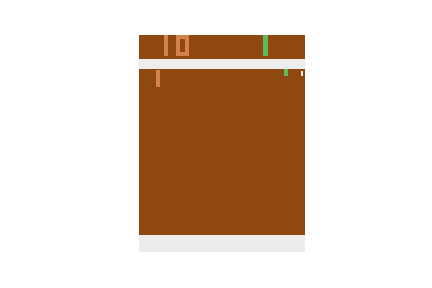
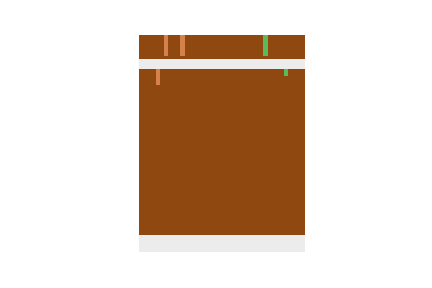
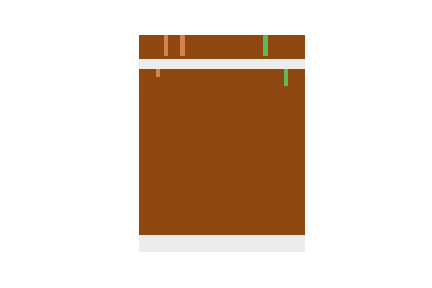
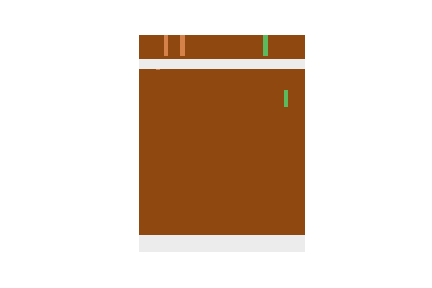
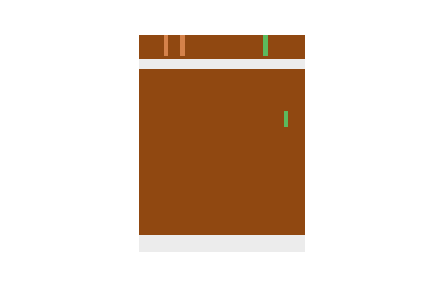
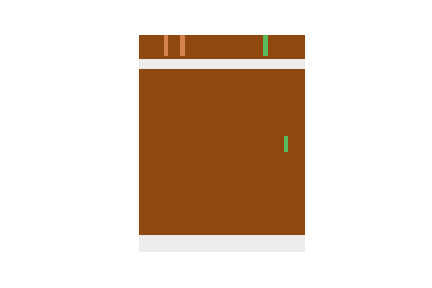
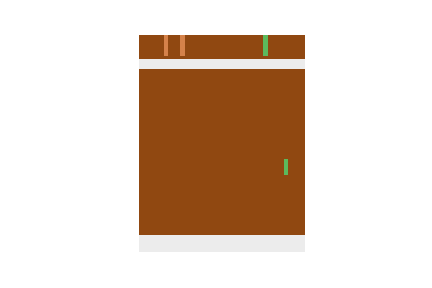
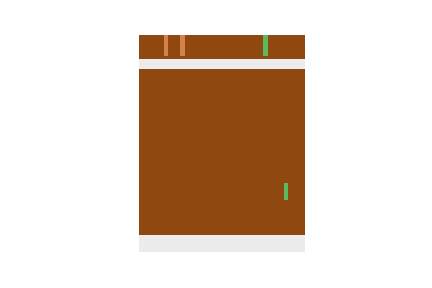
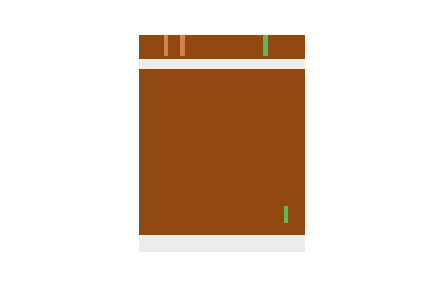
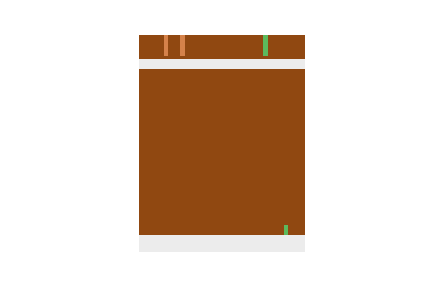
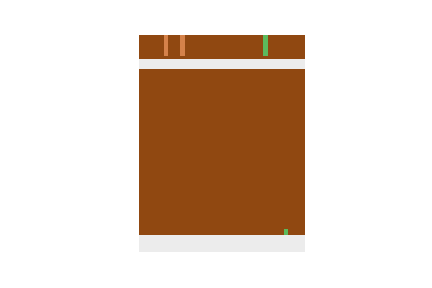
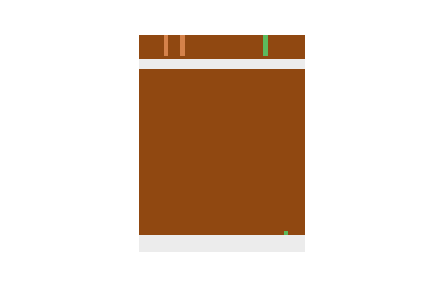
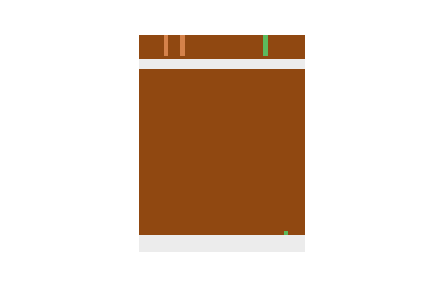
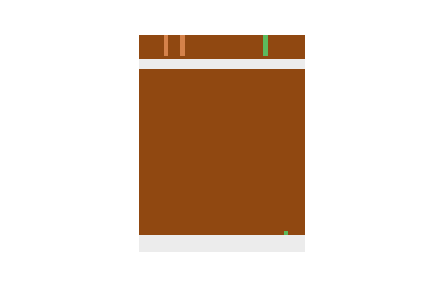
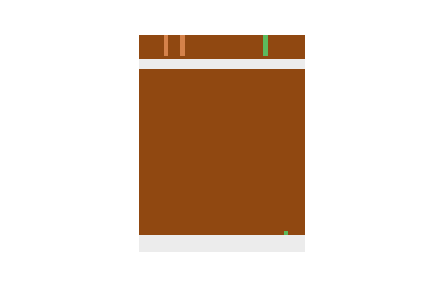
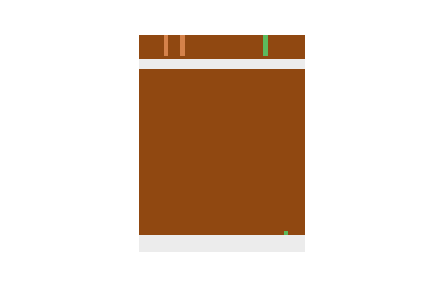
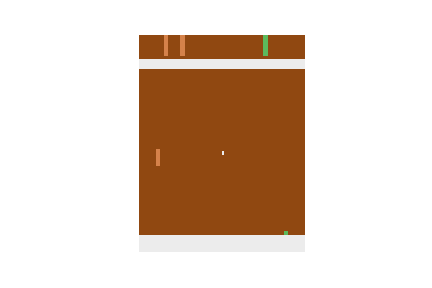
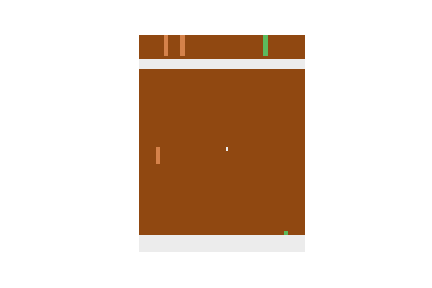
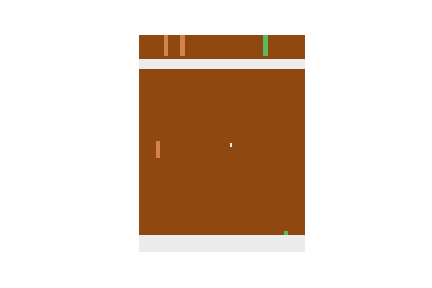
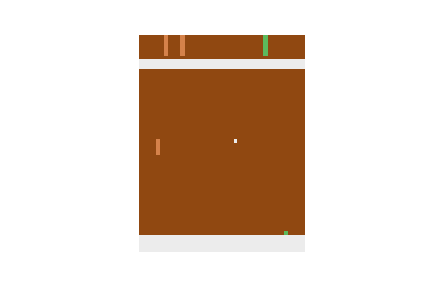
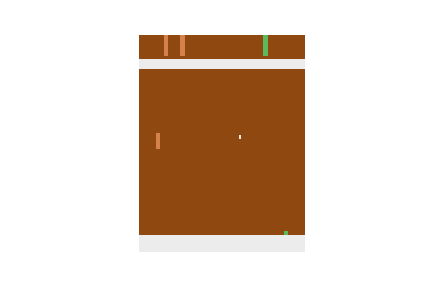
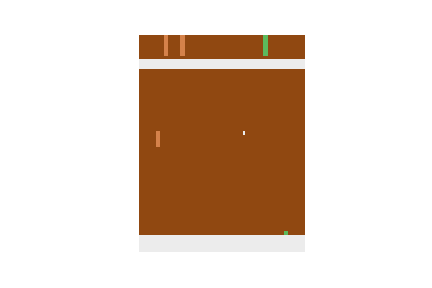
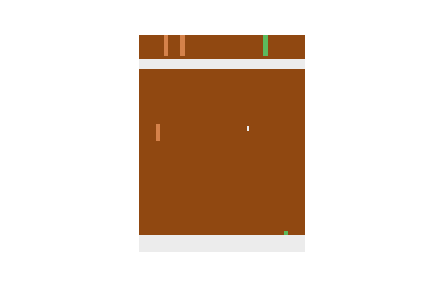
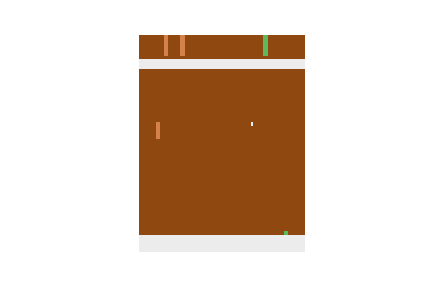
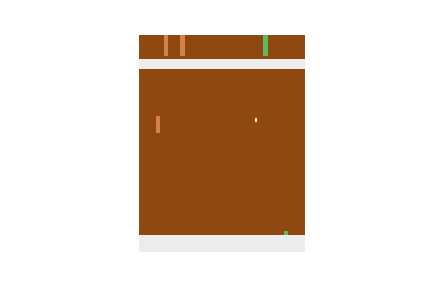
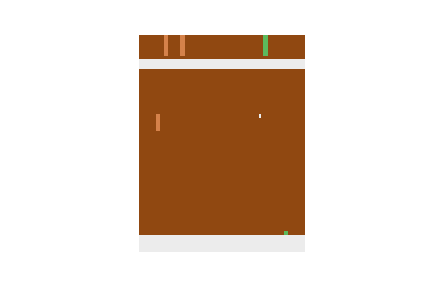
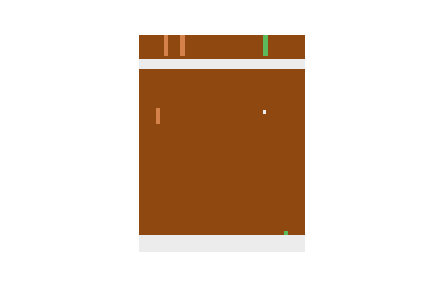
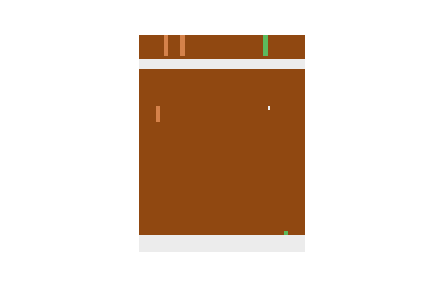
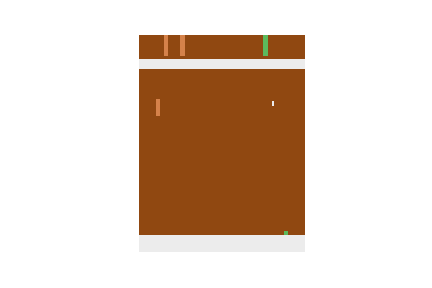
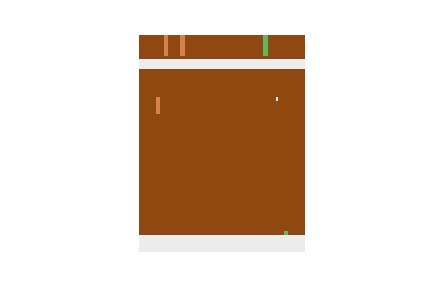
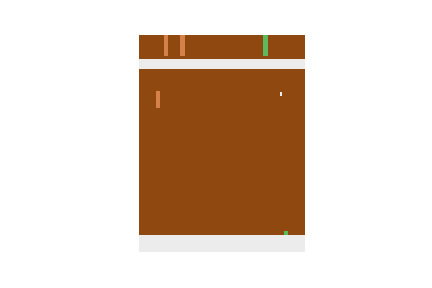
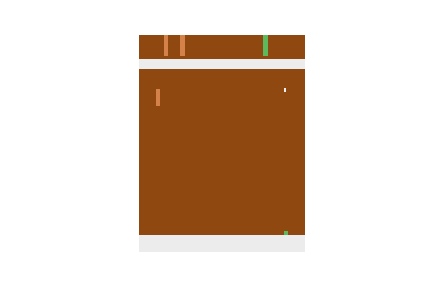
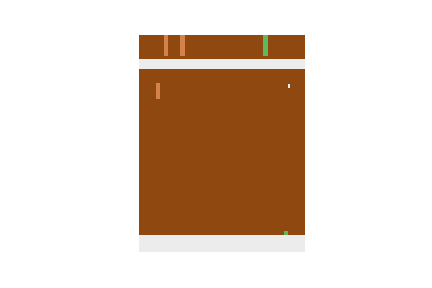
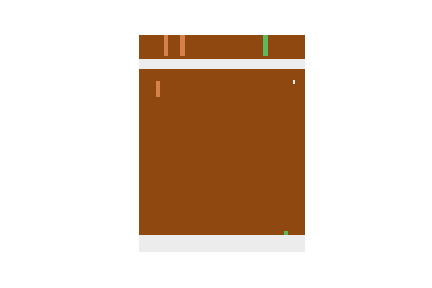
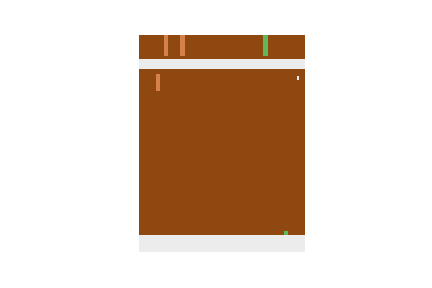
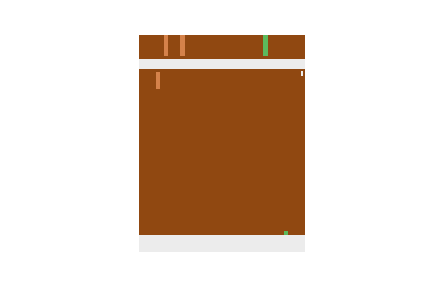
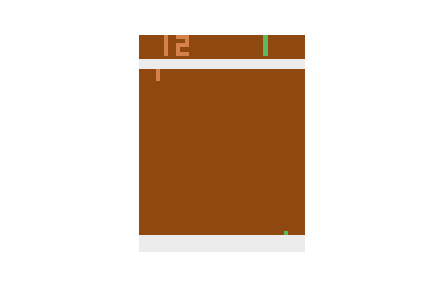
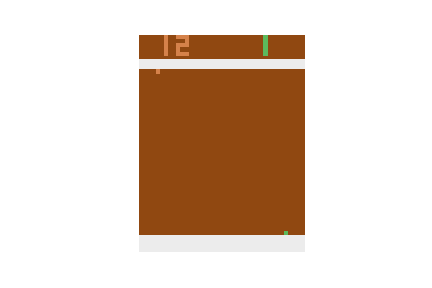
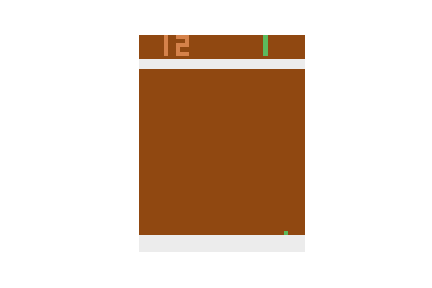
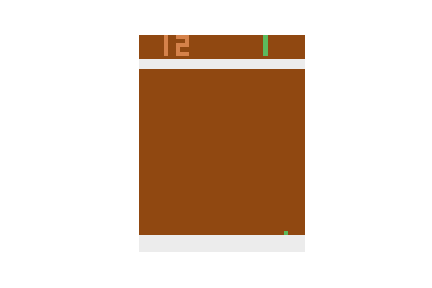
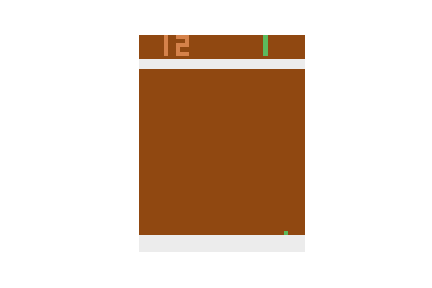
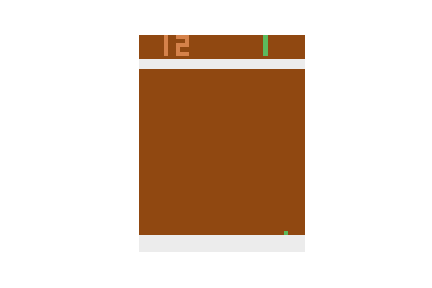
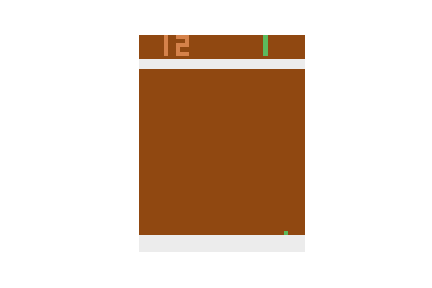
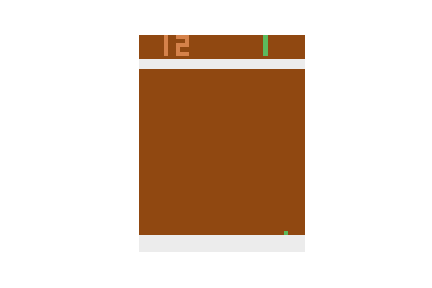
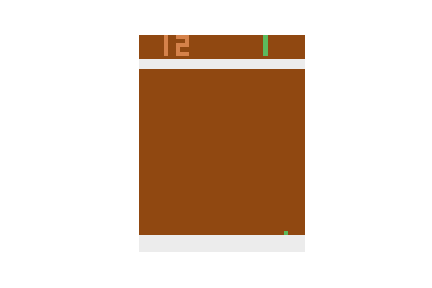
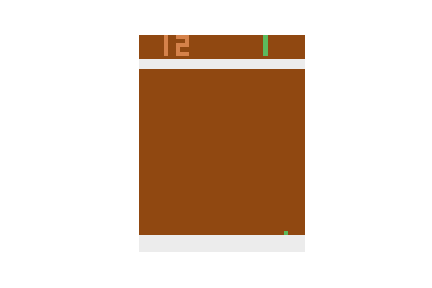
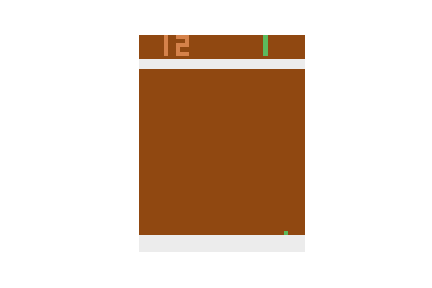
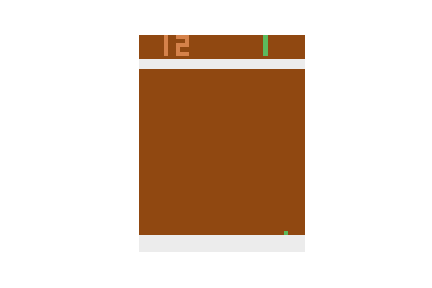
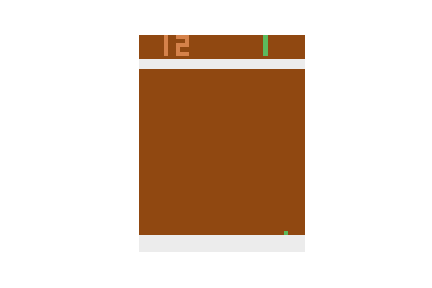
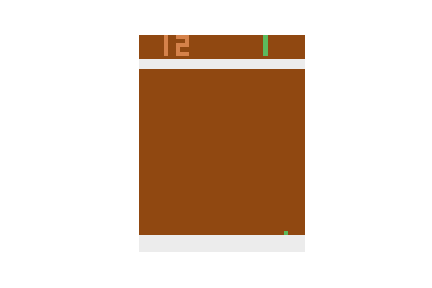
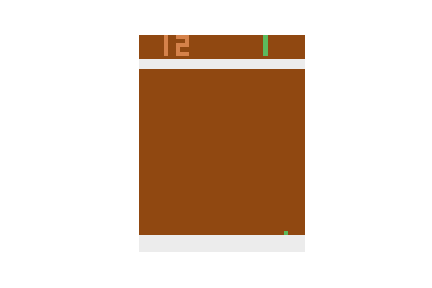
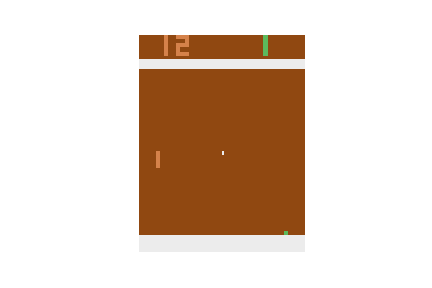
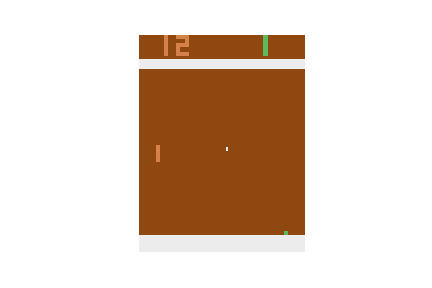
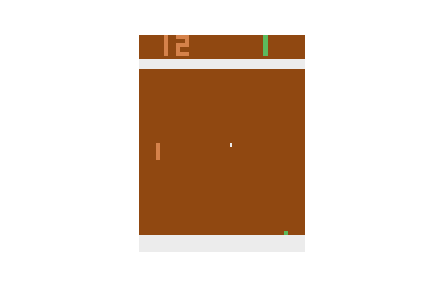
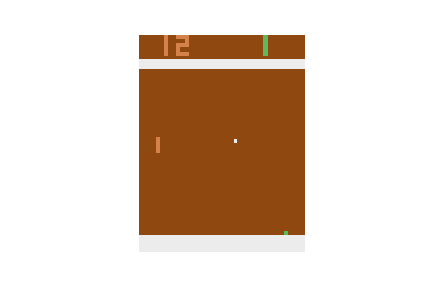
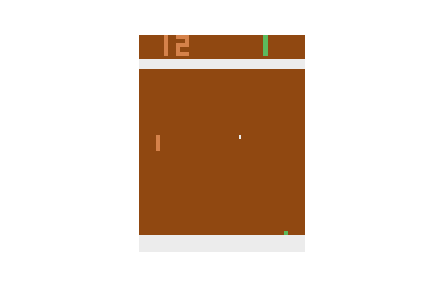
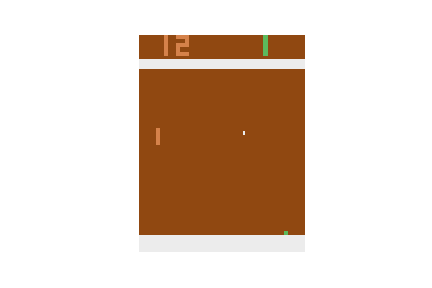
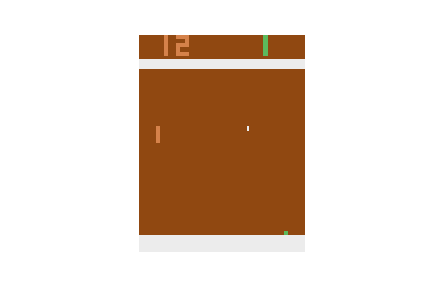
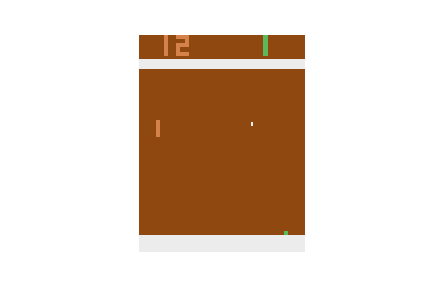
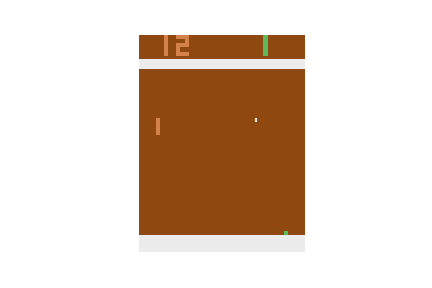
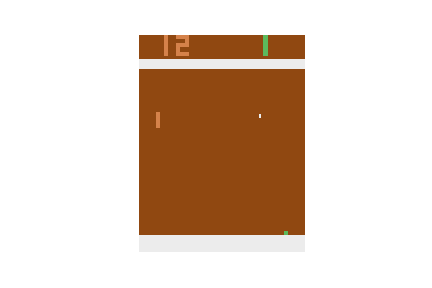
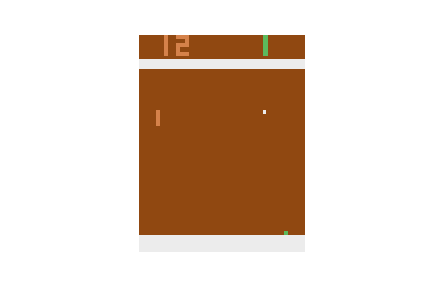
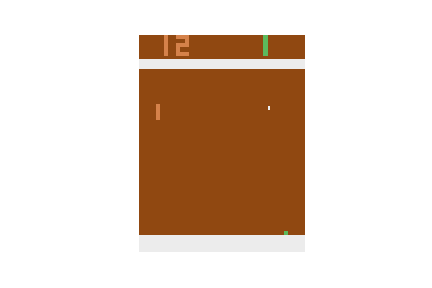
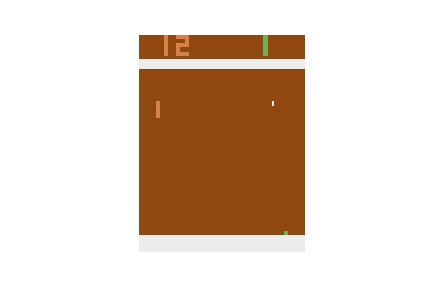
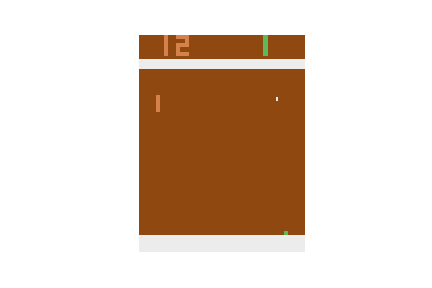
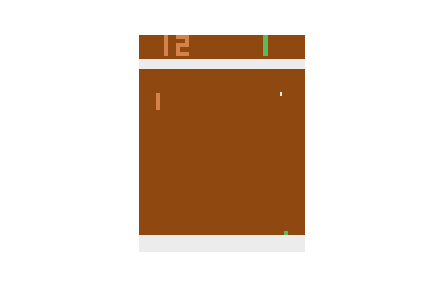
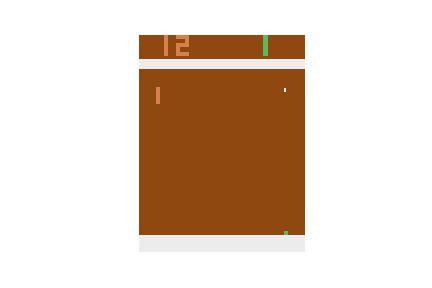
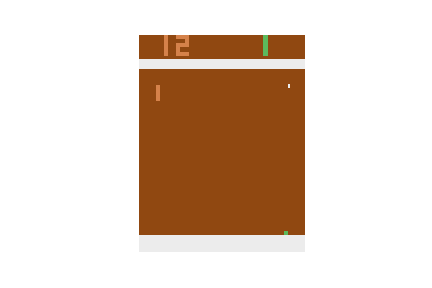
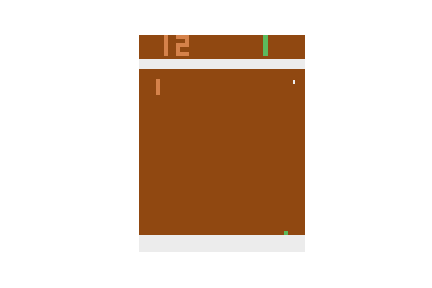
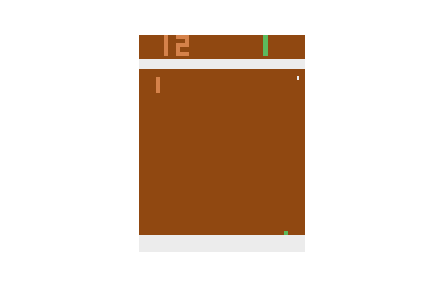
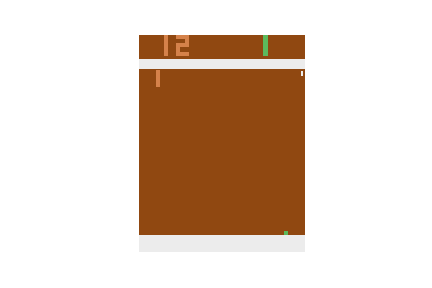
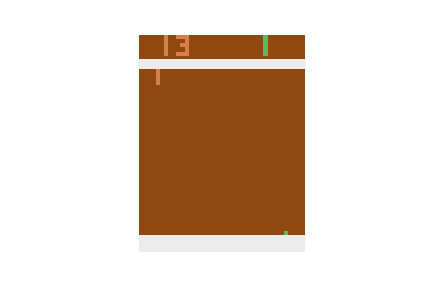
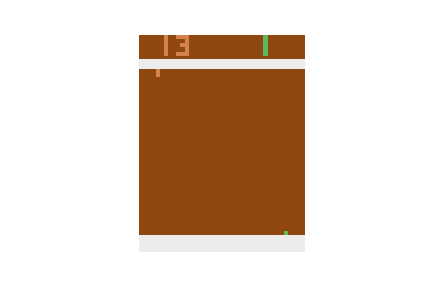
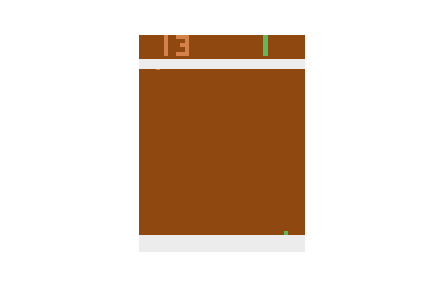
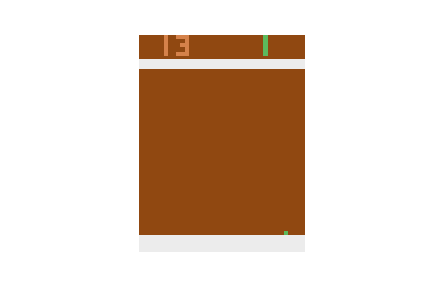
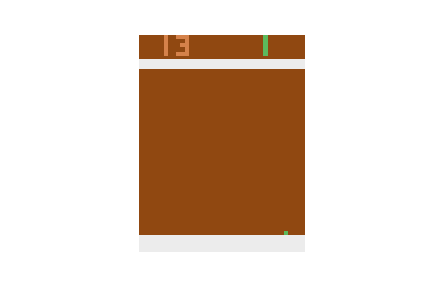
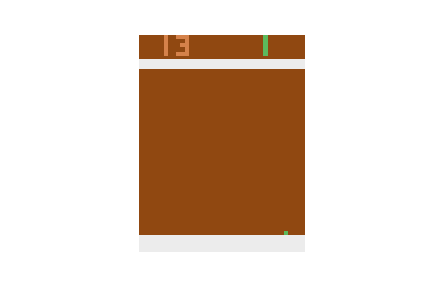
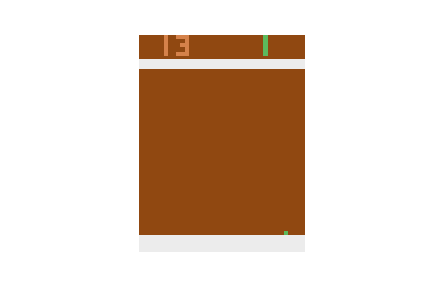
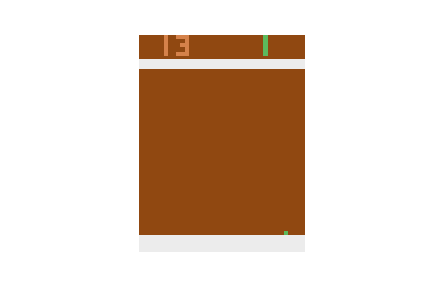
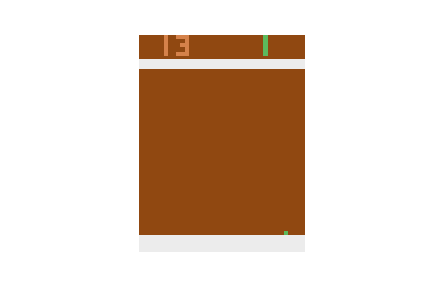
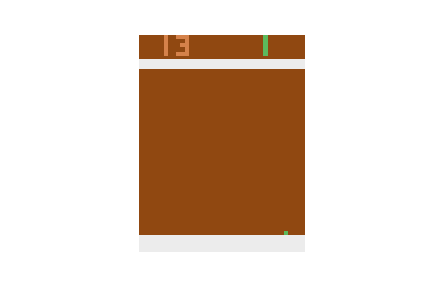
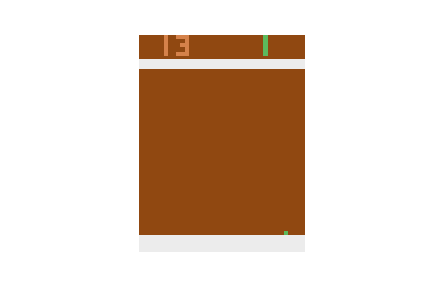
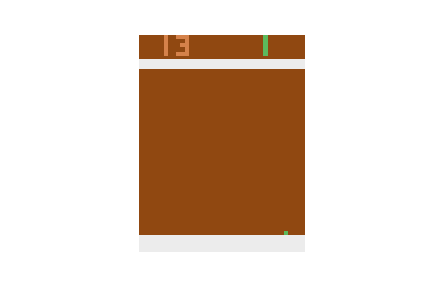
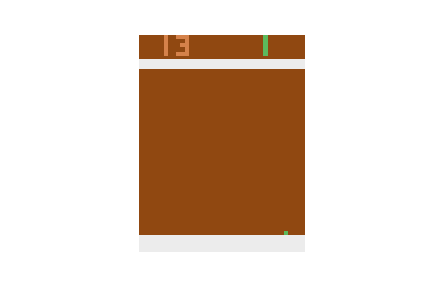
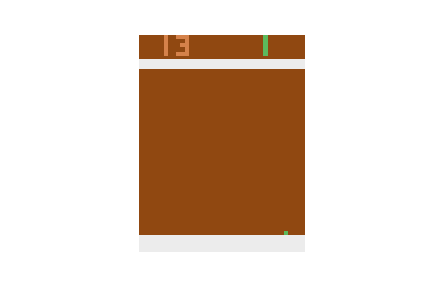
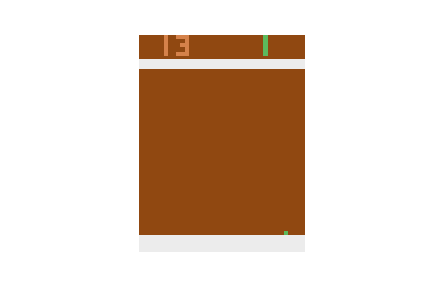
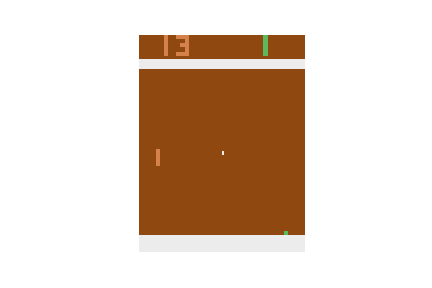
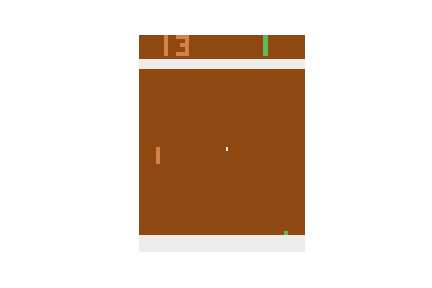
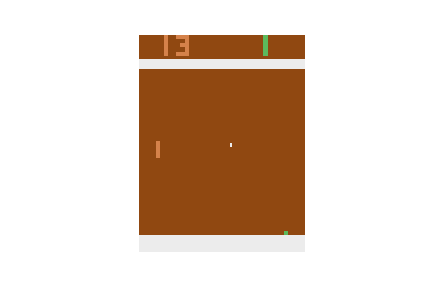
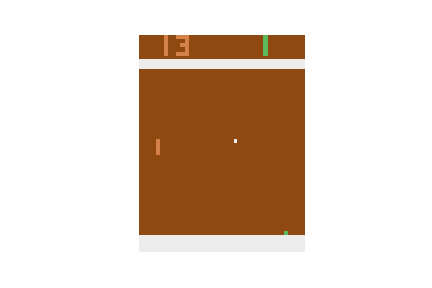
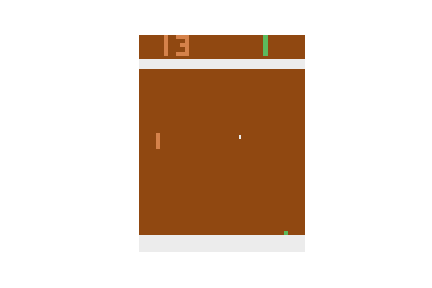
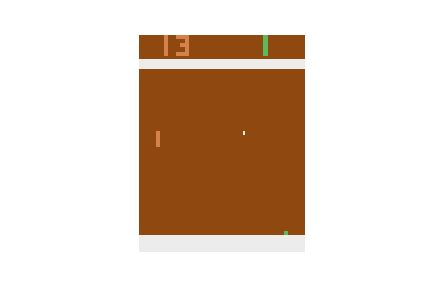
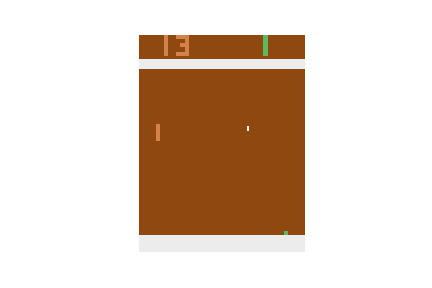
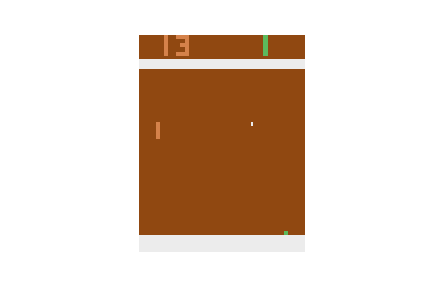
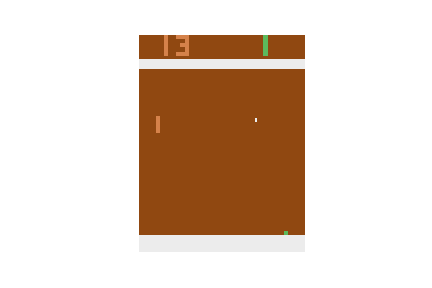
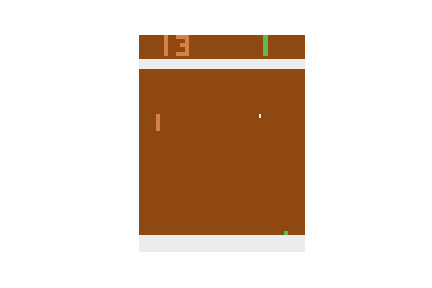
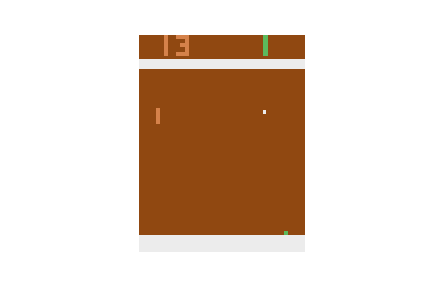
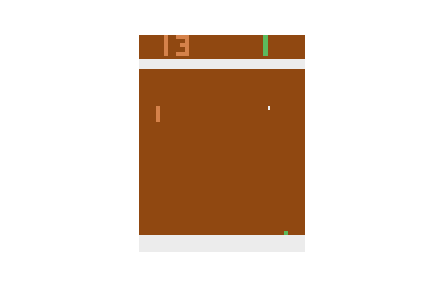
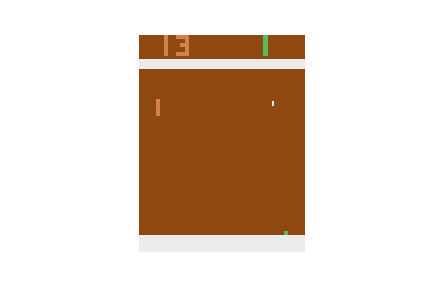
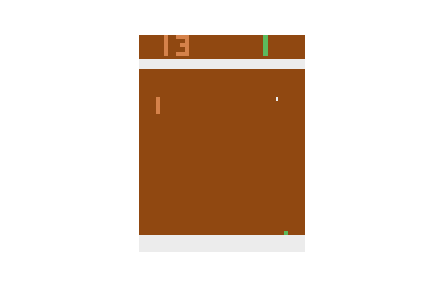
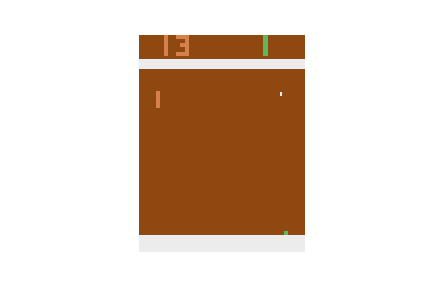

In [41]:
frames = []
observation = env.reset()
frames.append(env.render(mode = 'rgb_array'))
for t in range(100):
    observed = Variable(torch.FloatTensor(np.float32(observation)).unsqueeze(0))
    if CUDA:
        observed = observed.cuda()
    observed = observed.view(1, 1, 84, 84)
    action = model.action(observed, 0)
    observation, reward, done, info = env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    
    if done == True:
        observation = env.reset()

utils.display_frames(frames)

### Load Saved Model

In [13]:
model.load_state_dict(torch.load('./breakout_dqn_model_2'))
model.eval()

DQN(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=22528, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

### Save Model

In [63]:
torch.save(model.state_dict(), './breakout_dqn_model_2')